### Importing Libraries

In [135]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import matplotlib.pyplot as plt # matplotlib library to plot histogram later

### Data Collecting

#### Importing Neighborhood/Kecamatan data from Wikipedia

In [2]:
# Collecting neighborhood/kecamatan data from wikipedia using pd.read_html
df = pd.read_html('https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Kota_Surabaya')[0]

# Removing unecessary columns and rows
df = df.drop(columns=['Kode Kemendagri', 'Jumlah Kelurahan', 'Daftar Kelurahan'])

# We delete/drop TOTAL row
df = df.drop([0, 31])

In [3]:
df.head()

,Kecamatan
1,Benowo
2,Bubutan
3,Bulak
4,Dukuh Pakis
5,Gayungan


In [4]:
# Getting the dimension of data
df.shape

(30, 1)

#### Using geopy library to import geolocation(lat and long)

In [183]:
# We are using Nominatim to get Geocode for each Neighborhood
from geopy.extra.rate_limiter import RateLimiter

# We use delay function to delay between geocoding calls to avoid denied access.
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Create location column from applied geocode.
df['location'] = df['Kecamatan'].apply(geocode)

# Create point column containing longitude, latitude and altitude out of location column.
df['point'] = df['location'].apply(lambda loc:tuple(loc.point) if loc else None)

# Split point column into latitude, longitude and altitude column.
df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)


In [185]:
# We delete unused column, because we only need Neighborhood and its geolocation
df = df.drop(['location', 'point', 'altitude'], axis=1)

#### Complete view of Neighborhood/Kecamatan Data and its Location

In [24]:
df

,Kecamatan,latitude,longitude
1,Benowo,-7.228532,112.648143
2,Bubutan,-7.246596,112.731800
3,Bulak,-7.232046,112.784834
4,Dukuh Pakis,-7.291595,112.687224
5,Gayungan,-7.328102,112.724952
6,Genteng,-7.260499,112.745174
7,Gubeng,-7.284630,112.755632
8,Gunung Anyar,-7.338423,112.797441
9,Jambangan,-7.324331,112.715721
10,Karang Pilang,-7.332051,112.701807


In [26]:
df.shape

(30, 3)

### Exploring and Visualizing Neighborhoods/Kecamatan in Surabaya City

#### Locating Surabaya City

In [27]:
address = 'Surabaya, Jawa Timur'

geolocator = Nominatim(user_agent='vejryn@gmail.com')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Surabaya are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Surabaya are -7.2459717, 112.7378266.


#### Visualizing Neighborhoods/Kecamatan in Surabaya CIty

In [177]:
map_surabaya = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, kecamatan in zip(df['latitude'], df['longitude'], df['Kecamatan']):
    label = '{}'.format(kecamatan)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_surabaya)
    
map_surabaya

### Implementing Foursquare API to explore venues in Surabaya City

#### Defining Foursquare Credentials and Version

In [188]:
CLIENT_ID = '#'
CLIENT_SECRET = '#'
VERSION = '20180604'


print('My Credentials: ')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

My Credentials: 
CLIENT_ID: #
CLIENT_SECRET: #


#### Locating top 30 venues within 3000 meters of Neighborhoods

In [54]:
LIMIT = 30
radius = 3000
venues = []

for lat, long, kecamatan in zip(df['latitude'], df['longitude'], df['Kecamatan']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
        kecamatan,
        lat,
        long,
        venue['venue']['name'],
        venue['venue']['location']['lat'],
        venue['venue']['location']['lng'],
        venue['venue']['categories'][0]['name']))

#### Creating and Analyzing Venue Data collected from Foursquare API

In [57]:
# Creating venues dataframe from venues list value

venues_df = pd.DataFrame(venues)
venues_df.columns = ['Kecamatan', 'latitude', 'longitude', 'venue_name', 'venue_latitude', 'venue_longitude', 'venue_category']
venues_df.head(10)

,Kecamatan,latitude,longitude,venue_name,venue_latitude,venue_longitude,venue_category
0,Benowo,-7.228532,112.648143,Food Junction Grand Pakuwon,-7.250903,112.661927,Food Court
1,Benowo,-7.228532,112.648143,Pawon Ndeso,-7.243629,112.632808,Indonesian Restaurant
2,Benowo,-7.228532,112.648143,Stadion Gelora Bung Tomo,-7.223275,112.622938,Soccer Stadium
3,Benowo,-7.228532,112.648143,Indomaret,-7.237172,112.628458,Convenience Store
4,Benowo,-7.228532,112.648143,Food Junction Grand Pakuwon,-7.250883,112.662625,Food Court
5,Bubutan,-7.246596,112.731800,Museum Nasional 10 November,-7.245866,112.737800,History Museum
6,Bubutan,-7.246596,112.731800,CGV Cinemas,-7.254282,112.732692,Multiplex
7,Bubutan,-7.246596,112.731800,JW Marriott Hotel (Hotel JW Marriott),-7.259589,112.734653,Hotel
8,Bubutan,-7.246596,112.731800,Java Premium,-7.244716,112.720937,Coffee Shop
9,Bubutan,-7.246596,112.731800,Sinar Bahagia - Photography,-7.250746,112.738024,Hobby Shop


In [56]:
venues_df.shape

(829, 7)

#### Identifying total venues returned for each neighborhood

In [58]:
venues_df.groupby(["Kecamatan"]).count()

,latitude,longitude,venue_name,venue_latitude,venue_longitude,venue_category
Kecamatan,,,,,,
Benowo,5,5,5,5,5,5
Bubutan,30,30,30,30,30,30
Bulak,28,28,28,28,28,28
Dukuh Pakis,30,30,30,30,30,30
Gayungan,30,30,30,30,30,30
Genteng,30,30,30,30,30,30
Gubeng,30,30,30,30,30,30
Gunung Anyar,30,30,30,30,30,30
Jambangan,30,30,30,30,30,30


#### Identifying unique venue categories

In [62]:
print('There are {} unique venue categories.'.format(len(venues_df['venue_category'].unique())))

There are 121 unique venue categories.


#### Identifying if there are coffee shop in venue category

In [61]:
"Coffee Shop" in venues_df['venue_category'].unique()

True

### Analyzing Categorical Data of Venues in Each Neighborhood (Exploratory Data Analysis)

#### One Hot Encoding 

In [180]:
df_onehot = pd.get_dummies(venues_df[['venue_category']], prefix="", prefix_sep="")
df_onehot['Kecamatan'] = venues_df['Kecamatan']

In [181]:
column_list = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[column_list]
print(df_onehot.shape)
df_onehot.head()

(829, 122)


,Kecamatan,Airport Service,American Restaurant,Asian Restaurant,BBQ Joint,Baby Store,Bakery,Balinese Restaurant,Bar,Basketball Court,Batik Shop,Bed & Breakfast,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Breakfast Spot,Bubble Tea Shop,Building,Business Service,Café,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gastropub,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indonesian Meatball Place,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lounge,Market,Massage Studio,Middle Eastern Restaurant,Miscellaneous Shop,Mosque,Movie Theater,Multiplex,Music School,Music Venue,Nightclub,Noodle House,Outdoor Supply Store,Padangnese Restaurant,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pool,Pool Hall,Pub,Racetrack,Rest Area,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sculpture Garden,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Club,Steakhouse,Sundanese Restaurant,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Theme Park,Turkish Restaurant,Udon Restaurant,Water Park,Yoga Studio
0,Benowo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Benowo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Benowo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Benowo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Benowo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Grouping neighborhood/kecamatan and assign mean of the frequency of each categories by neighborhood/kecamatan

In [79]:
df_group = df_onehot.groupby(["Kecamatan"]).mean().reset_index()
df_group

,Kecamatan,Yoga Studio,Airport Service,American Restaurant,Asian Restaurant,BBQ Joint,Baby Store,Bakery,Balinese Restaurant,Bar,Basketball Court,Batik Shop,Bed & Breakfast,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Breakfast Spot,Bubble Tea Shop,Building,Business Service,Café,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gastropub,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indonesian Meatball Place,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lounge,Market,Massage Studio,Middle Eastern Restaurant,Miscellaneous Shop,Mosque,Movie Theater,Multiplex,Music School,Music Venue,Nightclub,Noodle House,Outdoor Supply Store,Padangnese Restaurant,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pool,Pool Hall,Pub,Racetrack,Rest Area,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sculpture Garden,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Club,Steakhouse,Sundanese Restaurant,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Theme Park,Turkish Restaurant,Udon Restaurant,Water Park
0,Benowo,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Bubutan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.033333,0.0,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.066667,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bulak,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.035714,0.035714,0.000000,0.035714,0.000000,0.000000,0.000000,0.00000

In [80]:
df_group.shape

(30, 122)

#### We will create a data frame containing coffee only shop as venue

In [81]:
df_coffeeshop = df_group[["Kecamatan", "Coffee Shop"]]

In [84]:
df_coffeeshop.head(10)

,Kecamatan,Coffee Shop
0,Benowo,0.000000
1,Bubutan,0.033333
2,Bulak,0.000000
3,Dukuh Pakis,0.166667
4,Gayungan,0.033333
5,Genteng,0.133333
6,Gubeng,0.066667
7,Gunung Anyar,0.100000
8,Jambangan,0.033333
9,Karang Pilang,0.000000


### Clustering Neighborhoods based on the presence of Coffee Shop

#### We will use Coffee Shop columns as variable for clustering, so we drop Neighborhoods/Kecamatan column first 

In [92]:
# number of clusters is set to 3
# use Coffee Shop column/variable to use in k-means clustering

df_cluster = df_coffeeshop.drop(["Kecamatan"], 1)
kmeans = KMeans(n_clusters= 3, random_state=0).fit(df_cluster)

In [93]:
# check labels in generated clusters
kmeans.labels_[0:8]

array([0, 0, 0, 1, 0, 1, 2, 2], dtype=int32)

#### Add generated labels into df_coffeeshop

In [95]:
df_coffeeshop["Cluster Labels"] = kmeans.labels_

/Users/1ovemachine/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [98]:
df_coffeeshop.head(10)

,Kecamatan,Coffee Shop,Cluster Labels
0,Benowo,0.000000,0
1,Bubutan,0.033333,0
2,Bulak,0.000000,0
3,Dukuh Pakis,0.166667,1
4,Gayungan,0.033333,0
5,Genteng,0.133333,1
6,Gubeng,0.066667,2
7,Gunung Anyar,0.100000,2
8,Jambangan,0.033333,0
9,Karang Pilang,0.000000,0


#### Merge the data containing the clusters and the data containing geolocation and use it as final data

In [103]:
df_final = df_coffeeshop.join(df.set_index("Kecamatan"), on="Kecamatan")

In [105]:
df_final.head(10)

,Kecamatan,Coffee Shop,Cluster Labels,latitude,longitude
0,Benowo,0.000000,0,-7.228532,112.648143
1,Bubutan,0.033333,0,-7.246596,112.731800
2,Bulak,0.000000,0,-7.232046,112.784834
3,Dukuh Pakis,0.166667,1,-7.291595,112.687224
4,Gayungan,0.033333,0,-7.328102,112.724952
5,Genteng,0.133333,1,-7.260499,112.745174
6,Gubeng,0.066667,2,-7.284630,112.755632
7,Gunung Anyar,0.100000,2,-7.338423,112.797441
8,Jambangan,0.033333,0,-7.324331,112.715721
9,Karang Pilang,0.000000,0,-7.332051,112.701807


#### Visualising Surabaya City Map with Clustered Marker for each Kecamatan

In [111]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

x = np.arange(3)
ys = [i+x+(i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

marker_colors = []
for lat, lng, kecamatan, cluster in zip(df_final['latitude'], df_final['longitude'], df_final['Kecamatan'], df_final['Cluster Labels']):
    label = folium.Popup('Kecamatan: ' + str(kecamatan) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
map_clusters

#### Cluster Distribution

As we see below, the concentration of Coffee Shop in Cluster 1 is High, we conclude that it's better to Develop a New Coffee Shop in Cluster 2.

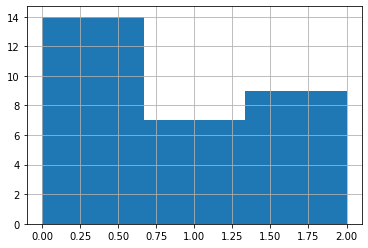

In [176]:
hist = df_final['Cluster Labels'].hist(bins=3)

### This conclude my analysis, full explanation is available on Blogpost and Report. Thank you for reviewing!